In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install deepxde
import re

import deepxde as dde
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from scipy.integrate import odeint
from matplotlib import cm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Using backend: tensorflow.compat.v1

Instructions for updating:
non-resource variables are not supported in the long term



## Safety PDE with data

In [3]:
import scipy.io
mat1 = scipy.io.loadmat('/content/drive/MyDrive/MC data/f(x) = 1/ground_truth.mat')
mat2 = scipy.io.loadmat('/content/drive/MyDrive/MC data/f(x) = 1/MC100.mat')
mat3 = scipy.io.loadmat('/content/drive/MyDrive/MC data/f(x) = 1/MC.mat')
mat4 = scipy.io.loadmat('/content/drive/MyDrive/MC data/f(x) = 1/MC10000.mat')
mat5 = scipy.io.loadmat('/content/drive/MyDrive/MC data/f(x) = 1/MC10e5.mat')
mat6 = scipy.io.loadmat('/content/drive/MyDrive/MC data/f(x) = 1/MC10.mat')
safety_pde = mat1['F2']
safety_pde.shape # (109, 10000)
MC100 = mat2['U2']
MC = mat3['U2']
MC10000 = mat4['U2']
MC10e5 = mat5['U2']
MC10 = mat6['U2']
MC.shape # (109, 10000)
safety_pde[50:109, ::100].shape # (59, 100)

safety_pde = safety_pde[50:109, ::100]
MC10 = MC10[50:109, ::100]
MC100 = MC100[50:109, ::100]
MC = MC[50:109, ::100]
MC10000 = MC10000[50:109, ::100]
MC10e5 = MC10e5[50:109, ::100]

bnd = np.ones([1,100])
bnd.shape # (1, 100)
safety_pde = np.append(safety_pde, bnd, axis=0)
MC10 = np.append(MC10, bnd, axis=0)
MC100 = np.append(MC100, bnd, axis=0)
MC1000 = np.append(MC, bnd, axis=0)
MC10000 = np.append(MC10000, bnd, axis=0)
MC10e5 = np.append(MC10e5, bnd, axis=0)

MC1000.shape # (60, 100)

(60, 100)

### PINN with different acc of MC training data

In [4]:
def pde(x, y):
    dy_t = dde.grad.jacobian(y, x, j=1)
    dy_x = dde.grad.jacobian(y, x, j=0)
    dy_xx = dde.grad.hessian(y, x, j=0)
    # Backend tensorflow.compat.v1 or tensorflow
    return (
        dy_t
        - 0.5 * dy_xx
        - 1 * dy_x
    )

In [5]:
observe_x = np.mgrid[-9.8:2.1:0.2, 0.1:10.1:0.1].reshape(2,-1).T
observe_x.shape # (6000, 2)

observe_func1 = MC10.reshape(-1,1)
observe_func2 = MC100.reshape(-1,1)
observe_func3 = MC1000.reshape(-1,1)
observe_func4 = MC10000.reshape(-1,1)
observe_func5 = MC10e5.reshape(-1,1)

In [6]:
observe_y1 = dde.icbc.PointSetBC(observe_x, observe_func1, component=0)
observe_y2 = dde.icbc.PointSetBC(observe_x, observe_func2, component=0)
observe_y3 = dde.icbc.PointSetBC(observe_x, observe_func3, component=0)
observe_y4 = dde.icbc.PointSetBC(observe_x, observe_func4, component=0)
observe_y5 = dde.icbc.PointSetBC(observe_x, observe_func5, component=0)

geom = dde.geometry.Interval(-10, 2)
timedomain = dde.geometry.TimeDomain(0, 10)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

data1 = dde.data.TimePDE(
    geomtime,
    pde,
    [observe_y1],
    num_domain=600,
    # num_boundary=20,
    # num_initial=10,
    anchors=observe_x,
)

data2 = dde.data.TimePDE(geomtime, pde, [observe_y2], num_domain=600, anchors=observe_x,)
data3 = dde.data.TimePDE(geomtime, pde, [observe_y3], num_domain=600, anchors=observe_x,)
data4 = dde.data.TimePDE(geomtime, pde, [observe_y4], num_domain=600, anchors=observe_x,)
data5 = dde.data.TimePDE(geomtime, pde, [observe_y5], num_domain=600, anchors=observe_x,)

/usr/local/lib/python3.7/dist-packages/skopt/sampler/sobol.py:250: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+602=602. 
  total_n_samples))


In [7]:
layer_size = [2] + [32] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

model1 = dde.Model(data1, net)

model1.compile(
    "adam", lr=0.001
)

model2 = dde.Model(data2, net)
model3 = dde.Model(data3, net)
model4 = dde.Model(data4, net)
model5 = dde.Model(data5, net)

model2.compile("adam", lr=0.001)
model3.compile("adam", lr=0.001)
model4.compile("adam", lr=0.001)
model5.compile("adam", lr=0.001)

/usr/local/lib/python3.7/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:110: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  kernel_constraint=self.kernel_constraint,


Compiling model...
Building feed-forward neural network...
'build' took 0.117118 s



/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:261: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


'compile' took 0.728344 s

Compiling model...
'compile' took 0.414521 s

Compiling model...
'compile' took 0.564729 s

Compiling model...
'compile' took 0.466704 s

Compiling model...
'compile' took 0.846249 s



In [8]:
model1.restore('/content/drive/MyDrive/DeepXDE models/model1-dense-600/model1-dense-600-60000.ckpt', verbose=1)
model2.restore('/content/drive/MyDrive/DeepXDE models/model2-dense-600/model2-dense-600-60000.ckpt', verbose=1)
model3.restore('/content/drive/MyDrive/DeepXDE models/model3-dense-600/model3-dense-600-60000.ckpt', verbose=1)
model4.restore('/content/drive/MyDrive/DeepXDE models/model4-dense-600/model4-dense-600-60000.ckpt', verbose=1)
model5.restore('/content/drive/MyDrive/DeepXDE models/model5-dense-600/model5-dense-600-60000.ckpt', verbose=1)

Restoring model from /content/drive/MyDrive/DeepXDE models/model1-dense-600/model1-dense-600-60000.ckpt ...

Restoring model from /content/drive/MyDrive/DeepXDE models/model2-dense-600/model2-dense-600-60000.ckpt ...

Restoring model from /content/drive/MyDrive/DeepXDE models/model3-dense-600/model3-dense-600-60000.ckpt ...

Restoring model from /content/drive/MyDrive/DeepXDE models/model4-dense-600/model4-dense-600-60000.ckpt ...

Restoring model from /content/drive/MyDrive/DeepXDE models/model5-dense-600/model5-dense-600-60000.ckpt ...



In [ ]:
# model1.train(epochs=60000, callbacks=[variable], model_save_path='/content/drive/MyDrive/DeepXDE models/model1-dense-600/model1-dense-600')
# model2.train(epochs=60000, callbacks=[variable], model_save_path='/content/drive/MyDrive/DeepXDE models/model2-dense-600/model2-dense-600')
# model3.train(epochs=60000, callbacks=[variable], model_save_path='/content/drive/MyDrive/DeepXDE models/model3-dense-600/model3-dense-600')
# model4.train(epochs=60000, callbacks=[variable], model_save_path='/content/drive/MyDrive/DeepXDE models/model4-dense-600/model4-dense-600')
# model5.train(epochs=60000, callbacks=[variable], model_save_path='/content/drive/MyDrive/DeepXDE models/model5-dense-600/model5-dense-600')

In [9]:
test_x = np.mgrid[-9.8:2.1:0.2, 0.1:10.1:0.1].reshape(2,-1).T
test_x.shape # (6000, 2)
test_y = safety_pde.reshape(-1,1)
test_y.shape # (6000, 1)

yhat1 = model1.predict(test_x)
yhat2 = model2.predict(test_x)
yhat3 = model3.predict(test_x)
yhat4 = model4.predict(test_x)
yhat5 = model5.predict(test_x)

safety_predict1 = yhat1.reshape(60,-1)
safety_predict2 = yhat2.reshape(60,-1)
safety_predict3 = yhat3.reshape(60,-1)
safety_predict4 = yhat4.reshape(60,-1)
safety_predict5 = yhat5.reshape(60,-1)

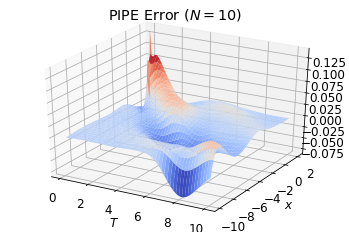

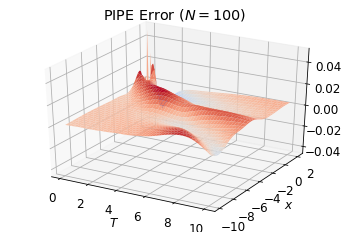

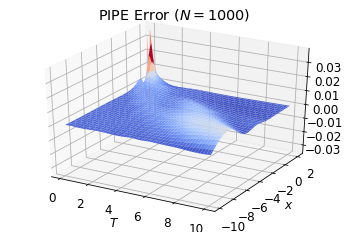

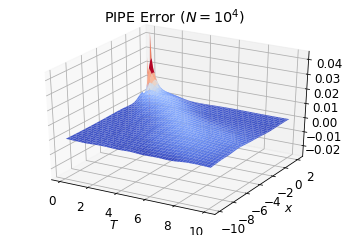

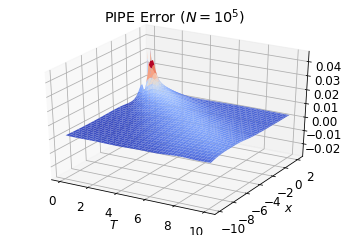

In [14]:
x = np.linspace(0.1,10,100)
y = np.linspace(-9.8,2,60)

X, Y = np.meshgrid(x, y)

import matplotlib
matplotlib.rcParams.update({'font.size': 12})

hf = plt.figure()
ha = hf.add_subplot(111, projection='3d')
ha.plot_surface(X, Y, safety_pde - safety_predict1, cmap=cm.coolwarm) # X: time, Y: state
ha.set_xlabel('$T$')
ha.set_ylabel('$x$')
ha.set_title("PIPE Error ($N=10$)")

hf = plt.figure()
ha = hf.add_subplot(111, projection='3d')
ha.plot_surface(X, Y, safety_pde - safety_predict2, cmap=cm.coolwarm) # X: time, Y: state
ha.set_xlabel('$T$')
ha.set_ylabel('$x$')
ha.set_title("PIPE Error ($N=100$)")

hf = plt.figure()
ha = hf.add_subplot(111, projection='3d')
ha.plot_surface(X, Y, safety_pde - safety_predict3, cmap=cm.coolwarm) # X: time, Y: state
ha.set_xlabel('$T$')
ha.set_ylabel('$x$')
ha.set_title("PIPE Error ($N=1000$)")

hf = plt.figure()
ha = hf.add_subplot(111, projection='3d')
ha.plot_surface(X, Y, safety_pde - safety_predict4, cmap=cm.coolwarm) # X: time, Y: state
ha.set_xlabel('$T$')
ha.set_ylabel('$x$')
ha.set_title("PIPE Error ($N=10^4$)")

hf = plt.figure()
ha = hf.add_subplot(111, projection='3d')
ha.plot_surface(X, Y, safety_pde - safety_predict5, cmap=cm.coolwarm) # X: time, Y: state
ha.set_xlabel('$T$')
ha.set_ylabel('$x$')
ha.set_title("PIPE Error ($N=10^5$)")

plt.show()

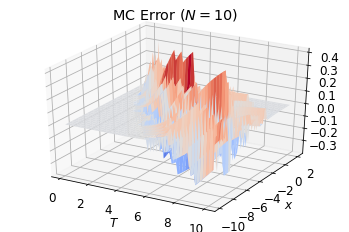

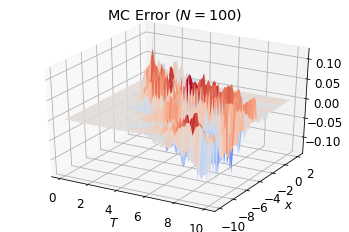

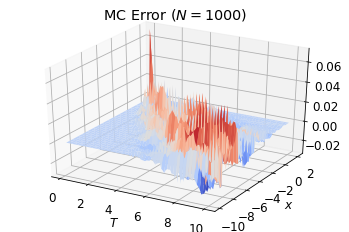

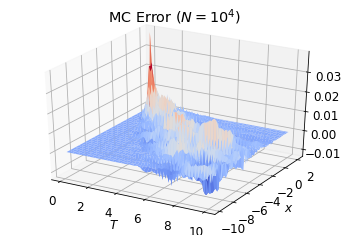

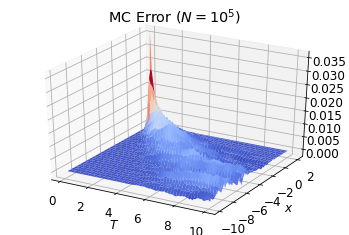

In [16]:
x = np.linspace(0.1,10,100)
y = np.linspace(-9.8,2,60)

X, Y = np.meshgrid(x, y)

hf = plt.figure()
ha = hf.add_subplot(111, projection='3d')
ha.plot_surface(X, Y, safety_pde - MC10, cmap=cm.coolwarm) # X: time, Y: state
ha.set_title("MC Error ($N=10$)")
ha.set_xlabel('$T$')
ha.set_ylabel('$x$')

hf = plt.figure()
ha = hf.add_subplot(111, projection='3d')
ha.plot_surface(X, Y, safety_pde - MC100, cmap=cm.coolwarm) # X: time, Y: state
ha.set_title("MC Error ($N=100$)")
ha.set_xlabel('$T$')
ha.set_ylabel('$x$')

hf = plt.figure()
ha = hf.add_subplot(111, projection='3d')
ha.plot_surface(X, Y, safety_pde - MC1000, cmap=cm.coolwarm) # X: time, Y: state
ha.set_title("MC Error ($N=1000$)")
ha.set_xlabel('$T$')
ha.set_ylabel('$x$')

hf = plt.figure()
ha = hf.add_subplot(111, projection='3d')
ha.plot_surface(X, Y, safety_pde - MC10000, cmap=cm.coolwarm) # X: time, Y: state
ha.set_title("MC Error ($N=10^4$)")
ha.set_xlabel('$T$')
ha.set_ylabel('$x$')

hf = plt.figure()
ha = hf.add_subplot(111, projection='3d')
ha.plot_surface(X, Y, safety_pde - MC10e5, cmap=cm.coolwarm) # X: time, Y: state
ha.set_title("MC Error ($N=10^5$)")
ha.set_xlabel('$T$')
ha.set_ylabel('$x$')

plt.show()

In [ ]:
np.average(safety_pde[40:50, 80:]) # 0.9885536695125748
np.average(safety_pde[20:40, 40:60]) # 0.4122788560441725

0.4122788560441725

In [ ]:
MCerror1 = safety_pde-MC10
MCerror2 = safety_pde-MC100
MCerror3 = safety_pde-MC1000
MCerror4 = safety_pde-MC10000
MCerror5 = safety_pde-MC10e5

# rare events
MC_rare_error = np.zeros([5,1])
MC_rare_error[0] = np.average(abs(MCerror1[40:50, 80:]))
MC_rare_error[1] = np.average(abs(MCerror2[40:50, 80:]))
MC_rare_error[2] = np.average(abs(MCerror3[40:50, 80:]))
MC_rare_error[3] = np.average(abs(MCerror4[40:50, 80:]))
MC_rare_error[4] = np.average(abs(MCerror5[40:50, 80:]))

# normal events
MC_normal_error = np.zeros([5,1])
MC_normal_error[0] = np.average(abs(MCerror1[20:40, 40:60]))
MC_normal_error[1] = np.average(abs(MCerror2[20:40, 40:60]))
MC_normal_error[2] = np.average(abs(MCerror3[20:40, 40:60]))
MC_normal_error[3] = np.average(abs(MCerror4[20:40, 40:60]))
MC_normal_error[4] = np.average(abs(MCerror5[20:40, 40:60]))

loop_num = np.array([10, 100, 1000, 10000, 100000])

print(MC_rare_error)
print(MC_normal_error)

[[0.01945228]
 [0.00580553]
 [0.00296573]
 [0.00057145]
 [0.00026656]]
[[0.10082404]
 [0.03927488]
 [0.01136837]
 [0.00491939]
 [0.00269128]]


In [ ]:
NNerror1 = safety_pde-safety_predict1
NNerror2 = safety_pde-safety_predict2
NNerror3 = safety_pde-safety_predict3
NNerror4 = safety_pde-safety_predict4
NNerror5 = safety_pde-safety_predict5

# rare events
print(np.average(abs(NNerror5[40:50, 80:])))
print(np.average(abs(MCerror5[40:50, 80:])))
NN_rare_error = np.zeros([5,1])
NN_rare_error[0] = np.average(abs(NNerror1[40:50, 80:]))
NN_rare_error[1] = np.average(abs(NNerror2[40:50, 80:]))
NN_rare_error[2] = np.average(abs(NNerror3[40:50, 80:]))
NN_rare_error[3] = np.average(abs(NNerror4[40:50, 80:]))
NN_rare_error[4] = np.average(abs(NNerror5[40:50, 80:]))

# normal events
print(np.average(abs(NNerror5[20:40, 40:60])))
print(np.average(abs(MCerror5[20:40, 40:60])))
NN_normal_error = np.zeros([5,1])
NN_normal_error[0] = np.average(abs(NNerror1[20:40, 40:60]))
NN_normal_error[1] = np.average(abs(NNerror2[20:40, 40:60]))
NN_normal_error[2] = np.average(abs(NNerror3[20:40, 40:60]))
NN_normal_error[3] = np.average(abs(NNerror4[20:40, 40:60]))
NN_normal_error[4] = np.average(abs(NNerror5[20:40, 40:60]))

loop_num = np.array([10, 100, 1000, 10000, 100000])

print(NN_rare_error)
print(NN_normal_error)

0.00013168698579569982
0.00026656403862121257
0.0024786529741279983
0.0026912806723029987
[[0.00506967]
 [0.00154437]
 [0.00044367]
 [0.0001367 ]
 [0.00013169]]
[[0.02156549]
 [0.00425291]
 [0.00358172]
 [0.00318862]
 [0.00247865]]


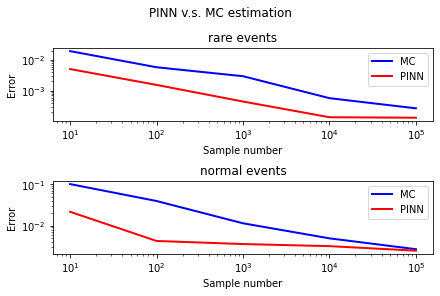

In [ ]:
fig, ax = plt.subplots(2, 1, constrained_layout=True)

ax[0].plot(loop_num, MC_rare_error, color='blue', lw=2, label='MC')
ax[0].plot(loop_num, NN_rare_error, color='red', lw=2, label='PINN')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_title('rare events')
ax[0].set_xlabel("Sample number")
ax[0].set_ylabel("Error")
ax[0].legend()

fig.suptitle('PINN v.s. MC estimation')

ax[1].plot(loop_num, MC_normal_error, color='blue', lw=2, label='MC')
ax[1].plot(loop_num, NN_normal_error, color='red', lw=2, label='PINN')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_title('normal events')
ax[1].set_xlabel("Sample number")
ax[1].set_ylabel("Error")
ax[1].legend()

plt.show()

### Rolling average of MC to denoise

Text(0.5, 0.92, 'MC denoise error')

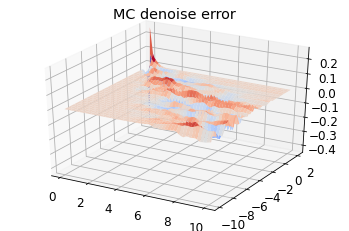

In [17]:
from scipy import ndimage
MC_denoise = ndimage.uniform_filter(MC100, size=3, mode='nearest')

x = np.linspace(0.1,10,100)
y = np.linspace(-9.8,2,60)
X, Y = np.meshgrid(x, y)

hf = plt.figure()
ha = hf.add_subplot(111, projection='3d')
# ha.set_xlim(8, 10)
# ha.set_ylim(0, 2)
# ha.set_zlim(-0.01, 0.01)
ha.plot_surface(X, Y, safety_pde - MC_denoise, cmap=cm.coolwarm) # X: time, Y: state
ha.set_title("MC denoise error")

In [ ]:
MC10_denoise = ndimage.uniform_filter(MC10, size=3, mode='nearest')
MC100_denoise = ndimage.uniform_filter(MC100, size=3, mode='nearest')
MC1000_denoise = ndimage.uniform_filter(MC1000, size=3, mode='nearest')
MC10000_denoise = ndimage.uniform_filter(MC10000, size=3, mode='nearest')
MC10e5_denoise = ndimage.uniform_filter(MC10e5, size=3, mode='nearest')

In [ ]:
MC_denoise_error = safety_pde - MC_denoise
print(np.average(abs(MC_denoise_error[40:50, 80:])))
print(np.average(abs(MC_denoise_error[20:40, 40:60])))

0.0016720052328489626
0.006502883978881051


In [ ]:
MCerror1_denoise = safety_pde-MC10_denoise
MCerror2_denoise = safety_pde-MC100_denoise
MCerror3_denoise = safety_pde-MC1000_denoise
MCerror4_denoise = safety_pde-MC10000_denoise
MCerror5_denoise = safety_pde-MC10e5_denoise

# rare events
MC_denoise_rare_error = np.zeros([5,1])
MC_denoise_rare_error[0] = np.average(abs(MCerror1_denoise[40:50, 80:]))
MC_denoise_rare_error[1] = np.average(abs(MCerror2_denoise[40:50, 80:]))
MC_denoise_rare_error[2] = np.average(abs(MCerror3_denoise[40:50, 80:]))
MC_denoise_rare_error[3] = np.average(abs(MCerror4_denoise[40:50, 80:]))
MC_denoise_rare_error[4] = np.average(abs(MCerror5_denoise[40:50, 80:]))

# normal events
MC_denoise_normal_error = np.zeros([5,1])
MC_denoise_normal_error[0] = np.average(abs(MCerror1_denoise[20:40, 40:60]))
MC_denoise_normal_error[1] = np.average(abs(MCerror2_denoise[20:40, 40:60]))
MC_denoise_normal_error[2] = np.average(abs(MCerror3_denoise[20:40, 40:60]))
MC_denoise_normal_error[3] = np.average(abs(MCerror4_denoise[20:40, 40:60]))
MC_denoise_normal_error[4] = np.average(abs(MCerror5_denoise[20:40, 40:60]))

loop_num = np.array([10, 100, 1000, 10000, 100000])

print(MC_denoise_rare_error)
print(MC_denoise_normal_error)

[[0.01267793]
 [0.00330984]
 [0.00167201]
 [0.00033381]
 [0.00026676]]
[[0.05914784]
 [0.0178148 ]
 [0.00650288]
 [0.00402926]
 [0.00255281]]


In [ ]:
loop_num = np.array([10, 100, 1000, 10000, 100000])

MC_denoise_rare_error = np.array([0.01267793, 0.00330984, 0.00167201, 0.00033381, 0.00026676])
MC_denoise_normal_error = np.array([0.05914784, 0.0178148, 0.00650288, 0.00402926, 0.00255281])

NN_rare_error = np.array([0.00506967, 0.00154437, 0.00044367, 0.0001367, 0.00013169])
NN_normal_error = np.array([0.02156549, 0.00425291, 0.00358172, 0.00318862, 0.00247865])

MC_rare_error = np.array([0.01945228, 0.00580553, 0.00296573, 0.00057145, 0.00026656])
MC_normal_error = np.array([0.10082404, 0.03927488, 0.01136837, 0.00491939, 0.00269128])

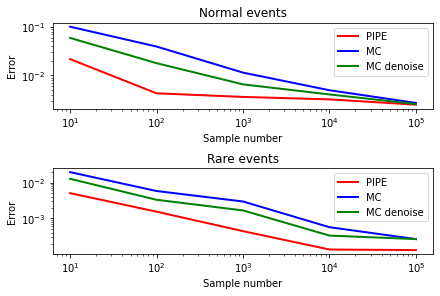

In [ ]:
fig, ax = plt.subplots(2, 1, constrained_layout=True)


# fig.suptitle('PINN v.s. MC estimation')

ax[0].plot(loop_num, NN_normal_error, color='red', lw=2, label='PIPE')
ax[0].plot(loop_num, MC_normal_error, color='blue', lw=2, label='MC')
ax[0].plot(loop_num, MC_denoise_normal_error, color='green', lw=2, label='MC denoise')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_title('Normal events')
ax[0].set_xlabel("Sample number")
ax[0].set_ylabel("Error")
ax[0].legend()

ax[1].plot(loop_num, NN_rare_error, color='red', lw=2, label='PIPE')
ax[1].plot(loop_num, MC_rare_error, color='blue', lw=2, label='MC')
ax[1].plot(loop_num, MC_denoise_rare_error, color='green', lw=2, label='MC denoise')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_title('Rare events')
ax[1].set_xlabel("Sample number")
ax[1].set_ylabel("Error")
ax[1].legend()

In [ ]:
# np.average(safety_pde[40:50, 80:]) # 0.9885536695125748
# np.average(safety_pde[20:40, 40:60]) # 0.4122788560441725
NN_normal_error_perc = NN_normal_error / (1-0.4122788560441725)
MC_normal_error_perc = MC_normal_error / (1-0.4122788560441725)
MC_denoise_normal_error_perc = MC_denoise_normal_error / (1-0.4122788560441725) 
MC_denoise_normal_error_perc

NN_rare_error_perc = NN_rare_error / (1-0.9885536695125748) 
MC_rare_error_perc = MC_rare_error / (1-0.9885536695125748) 
MC_denoise_rare_error_perc = MC_denoise_rare_error / (1-0.9885536695125748) 
MC_denoise_rare_error_perc

array([1.10759776, 0.28916167, 0.14607389, 0.02916306, 0.02330529])

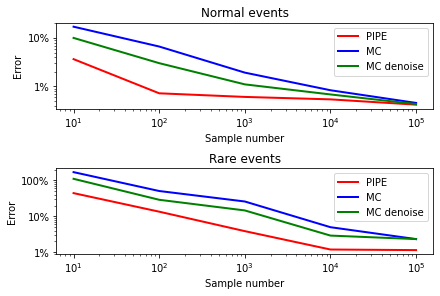

In [ ]:
fig, ax = plt.subplots(2, 1, constrained_layout=True)
import matplotlib.ticker as mtick

# fig.suptitle('PINN v.s. MC estimation')

ax[0].plot(loop_num, NN_normal_error_perc, color='red', lw=2, label='PIPE')
ax[0].plot(loop_num, MC_normal_error_perc, color='blue', lw=2, label='MC')
ax[0].plot(loop_num, MC_denoise_normal_error_perc, color='green', lw=2, label='MC denoise')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].yaxis.set_major_formatter(mtick.PercentFormatter())
vals = ax[0].get_yticks()
ax[0].set_yticklabels(['{:,.0%}'.format(x) for x in vals])
ax[0].set_title('Normal events')
ax[0].set_xlabel("Sample number")
ax[0].set_ylabel("Error")
ax[0].legend()

ax[1].plot(loop_num, NN_rare_error_perc , color='red', lw=2, label='PIPE')
ax[1].plot(loop_num, MC_rare_error_perc , color='blue', lw=2, label='MC')
ax[1].plot(loop_num, MC_denoise_rare_error_perc , color='green', lw=2, label='MC denoise')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].yaxis.set_major_formatter(mtick.PercentFormatter())
vals = ax[1].get_yticks()
ax[1].set_yticklabels(['{:,.0%}'.format(x) for x in vals])
ax[1].set_title('Rare events')
ax[1].set_xlabel("Sample number")
ax[1].set_ylabel("Error")
ax[1].legend()

# plt.show()

plt.savefig('PINN MC log plot perc.pdf')